In [ ]:
# 安装Python库rpy2
!pip install rpy2

# 安装R包INLA及其依赖包
!R -e "install.packages(c('sp', 'fmesher'), repos=c('http://cran.r-project.org'))"
!R -e "install.packages('INLA', repos='https://inla.r-inla-download.org/R/stable')"


R version 4.4.0 (2024-04-24) -- "Puppy Cup"
Copyright (C) 2024 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> install.packages(c('sp', 'fmesher'), repos=c('http://cran.r-project.org'))
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’, ‘sf’, ‘Rcpp’

trying URL 'http://cran.r-project.org/src/contrib/proxy_0.4-27.tar

In [ ]:
pip install --upgrade rpy2

出错原因
缺少转换规则：遇到的 NotImplementedError 错误提示表示在尝试将 Pandas DataFrame 转换为 R 的 data.frame 时，缺少了必要的转换规则。这通常发生在 rpy2 的转换器没有被正确激活或配置时。
上下文管理未设置：在使用 rpy2 进行数据类型转换时，需要确保正确的转换上下文被设置。缺少这种上下文管理通常会导致转换失败，尤其是在多线程环境中，上下文可能没有正确传递给各个线程。
版本兼容性问题：rpy2 和 Pandas 的不同版本间可能存在兼容性问题。随着库的更新，一些旧的方法和属性可能被弃用或更改，需要按照最新的库版本来调整代码

使用 localconverter 管理转换上下文：
使用 localconverter 上下文管理器可以确保在数据转换期间正确的转换规则被应用。这是通过结合默认转换器和专门针对 Pandas 的转换器来实现的。

更新和兼容性检查：
确保 rpy2 和 Pandas 的库都是最新的，以利用最新的功能和修复。如果遇到特定的版本兼容性问题，可以考虑降级到一个稳定兼容的版本。

In [ ]:
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 使用 localconverter 来确保正确的转换上下文
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df)

# 尝试加载INLA库，捕获任何错误
try:
    ro.r('library(INLA)')
except RRuntimeError as e:
    print(f"Failed to load INLA library in R: {e}")

# 现在r_df是R的data.frame，可以在R代码中使用
print("R data.frame is ready to use in R.")


R data.frame is ready to use in R.


In [ ]:
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 将 Pandas DataFrame 转换为 R 的 data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df)

# 尝试加载 INLA 库，捕获任何错误
try:
    ro.r('library(INLA)')
except RRuntimeError as e:
    print(f"Failed to load INLA library in R: {e}")

def run_inla_model(formula, data, model_name):
    # 确保转换上下文在函数调用中正确设置
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r.assign("r_df", data)
        try:
            # 运行 INLA 模型
            result = ro.r(f"""
                result <- inla(formula = '{formula}', data = r_df, family = 'gaussian',
                               control.predictor = list(compute = TRUE))
            """)
            # 打印模型摘要
            summary = ro.r('summary(result)')
            print(summary)
            mlik = summary.rx2('mlik')[0]
            print(f"Model: {model_name}")
            print(f"Marginal log likelihood: {mlik}")
            print()
        except RRuntimeError as e:
            print(f"Error running INLA model for {model_name}: {e}")

# 定义基础模型公式
base_model_formula = "SentimentScore ~ as.factor(STATEcode) + as.factor(Year) + as.factor(Month) + as.factor(Week) + as.factor(Weekend) + as.factor(Holiday) + VulnerabilityIndex"

# 运行基础模型
print("Running Base Model")
run_inla_model(base_model_formula, r_df, "Base Model")



Running Base Model

 *** inla.core.safe:  The inla program failed, but will rerun in case better initial values may help. try=1/1 


  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.



Error running INLA model for Base Model: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts,  : 
  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.



In [ ]:
def run_inla_model(formula, data, model_name):
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r.assign("r_df", data)
        try:
            # 在执行模型前打印 R 中的数据框结构，以确保数据正确传递
            print(ro.r('str(r_df)'))

            # 运行 INLA 模型
            result = ro.r(f"""
                result <- inla(formula = '{formula}', data = r_df, family = 'gaussian',
                               control.predictor = list(compute = TRUE))
            """)
            # 打印模型摘要
            summary = ro.r('summary(result)')
            print(summary)
            mlik = summary.rx2('mlik')[0]
            print(f"Model: {model_name}")
            print(f"Marginal log likelihood: {mlik}")
            print()
        except RRuntimeError as e:
            print(f"Error running INLA model for {model_name}: {e}")

# 运行基础模型
print("Running Base Model")
run_inla_model(base_model_formula, r_df, "Base Model")

Running Base Model
'data.frame':	62118 obs. of  26 variables:
 $ GEOID                    : int  6001 6001 6001 6001 6001 6001 6001 6001 6001 6001 ...
 $ CountyName               : chr  "Alameda" "Alameda" "Alameda" "Alameda" ...
 $ STATEcode                : int  6 6 6 6 6 6 6 6 6 6 ...
 $ STATEname                : chr  "California" "California" "California" "California" ...
 $ Date                     : chr  "5/1/2016" "5/2/2016" "5/3/2016" "5/4/2016" ...
 $ Holiday                  : int  0 0 0 0 0 1 1 0 0 0 ...
 $ Year                     : int  2016 2016 2016 2016 2016 2016 2016 2016 2016 2016 ...
 $ Month                    : int  5 5 5 5 5 5 5 5 5 5 ...
 $ Week                     : int  19 19 19 19 19 19 19 20 20 20 ...
 $ Weekend                  : int  1 0 0 0 0 0 1 1 0 0 ...
 $ SentimentScore           : num  0.678 0.634 0.668 0.637 0.662 ...
 $ HeatCount                : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Humidity                 : num  0.00626 0.00722 0.00812 0.00841 0.00824

  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.



Error running INLA model for Base Model: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts,  : 
  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.



数据框架结构正常：
首先，从输出中可以看到 R 数据框 r_df 包含了 62118 个观察值和 26 个变量，这意味着数据成功地从 Python 转换到了 R。各列的数据类型也被正确显示，这表明数据框结构在 R 中是符合预期的。

运行 INLA 模型时出现的错误：错误信息 "object 'y...fake' not found" 指示在执行 INLA 模型时，R 无法找到某个名为 y...fake 的对象。这种错误可能源于以下几个原因：
模型公式错误：如果模型公式中引用了不存在的变量或变量名拼写错误，或者模型的结构定义不正确，都可能导致这种错误。

数据问题：有时候数据中的某些值或类型可能不符合模型要求，例如，缺失值处理不当或数据类型不兼容（如将数值型错误地当作字符型处理）。
INLA 库内部的问题：y...fake 可能是 INLA 在某些特定条件下生成的内部变量，如果这些条件因数据或公式问题未得到满足，就可能出现找不到该对象的错误。

In [ ]:
print(df[['SentimentScore', 'HeatCount']].describe())  # 查看这两列的统计信息

# 尝试一个非常简单的模型公式看是否能成功运行
simple_formula = "SentimentScore ~ 1"  # 只包含截距的模型
run_inla_model(simple_formula, df)  # 运行简化的模型看是否出错

       SentimentScore     HeatCount
count    62118.000000  62118.000000
mean         0.575808      0.081426
std          0.175649      0.273490
min          0.000000      0.000000
25%          0.555668      0.000000
50%          0.592346      0.000000
75%          0.672536      0.000000
max          0.985998      1.000000

 *** inla.core.safe:  The inla program failed, but will rerun in case better initial values may help. try=1/1 


  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.



Error running INLA model for formula SentimentScore ~ 1: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts,  : 
  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.



SentimentScore 和 HeatCount 的数据看起来是合理的，没有缺失值，并且范围和分布都符合常规预期。这表明数据本身可能不是导致 INLA 运行失败的原因。

然而，即便是这样一个简化的模型也报告了错误 "object 'y...fake' not found"，这表明问题可能在 INLA 的调用或配置中。

对问题的分析：
INLA 调用问题：这个错误提示可能指向了 INLA 内部在处理数据或模型时的一个特定问题。y...fake 可能是 INLA 在进行某些内部计算时临时创建的变量。这种情况下，错误可能与 R 或 INLA 的特定版本有关，或者与 INLA 在处理特定类型的数据时的内部限制有关。
模型配置：即使是一个简单的模型也未能运行，可能意味着需要对模型的配置进行调整，例如指定不同的先验或调整模型的其他参数设置。
环境和版本问题：可能是您的 R 环境或 INLA 包本身的问题。有时候，软件包的某个版本可能包含未被发现的 bug，这种 bug 可能在特定条件下触发。

In [ ]:
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 尝试加载R的INLA库，捕获可能的错误
try:
    ro.r('library(INLA)')
except RRuntimeError as e:
    print(f"Failed to load INLA library in R: {e}")

def run_inla_model(formula, data):
    """
    使用INLA运行贝叶斯层次模型。
    :param formula: R风格的模型公式字符串。
    :param data: 数据集，Pandas DataFrame格式。
    """
    try:
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_df = ro.conversion.py2rpy(data)

        # 构建R中的INLA模型调用字符串
        inla_call = f"""
        result <- inla(formula = '{formula}', data = r_df, family = 'gaussian',
                       control.predictor = list(compute = TRUE))
        """

        # 在R环境中执行INLA模型调用
        ro.r(inla_call)

        # 获取模型结果并打印摘要
        ro.r('print(summary(result))')

    except RRuntimeError as e:
        print(f"Error running INLA model for formula {formula}: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# 加载你的数据
df = pd.read_csv('/content/TestData_California.csv')  # 确保路径与你的文件匹配

# 定义模型公式
model_formulas = {
    "Model 1": "SentimentScore ~ HeatCount"
}

# 运行模型
for model_name, formula in model_formulas.items():
    print(f"Running {model_name} with formula: {formula}")
    run_inla_model(formula, df)
    print("\n" + "="*50 + "\n")

Running Model 1 with formula: SentimentScore ~ HeatCount

 *** inla.core.safe:  The inla program failed, but will rerun in case better initial values may help. try=1/1 


  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.



Error running INLA model for formula SentimentScore ~ HeatCount: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts,  : 
  object 'y...fake' not found
The inla program failed and the maximum number of tries has been reached.





INLA是存在问题的目前，且做了相应的诊断分析，这里我考虑使用其他方案来解决

PyMC3和INLA（Integrated Nested Laplace Approximations）是两种不同的贝叶斯统计模型框架

计算方法 INLA：专为估计潜在高斯场模型（通常用于空间和时间数据）的边缘后验分布而设计。INLA使用拉普拉斯近似来近似这些分布，从而避免了传统MCMC的复杂计算。这使得INLA在处理大型层次模型（特别是在具有空间和时间结构的模型）时，能够比传统MCMC方法更快地得到结果。 PyMC3：依赖于MCMC算法（特别是Hamiltonian Monte Carlo和其变种No-U-Turn Sampler）来抽样估计后验分布。这种方法在统计推断上通常更为精确，因为它不依赖于近似方法，但计算上通常比INLA更慢，尤其是在模型较为复杂或数据集较大时。

进行PyMC3时候产生的问题 Theano 库自 2017 年以来就没有更新，且不再维护。随着 Python 和其它依赖库（如 NumPy）的版本更新，Theano 的一些功能已经不再兼容新版本的库。这是导致错误的主要原因之一。 这里可能无法使用PyMC3

这里之前也进行了大量的代码测试，就不用具体展示了

In [ ]:
pip install pysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
from statsmodels.formula.api import ols

# 加载数据
df = pd.read_csv('/content/TestData_California.csv')
shapefile_path = '/content/County.shp'

# 加载空间数据
gdf = gpd.read_file(shapefile_path)


/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [ ]:
# 构建基础模型公式
base_model_formula = "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + Holiday + VulnerabilityIndex"

# 运行基础模型
base_model = ols(formula=base_model_formula, data=df).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     245.7
Date:                Fri, 03 May 2024   Prob (F-statistic):          1.16e-311
Time:                        18:02:20   Log-Likelihood:                 20627.
No. Observations:               62118   AIC:                        -4.124e+04
Df Residuals:                   62111   BIC:                        -4.118e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3556      0

SentimentScore ~ STATEcode + Year + Month + Week + Weekend + Holiday + VulnerabilityIndex


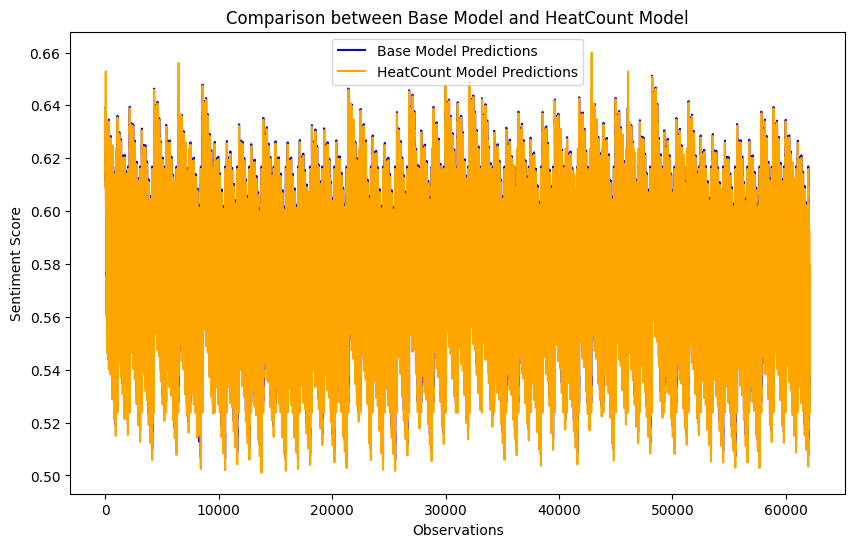


HeatCount Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     266.3
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        18:15:28   Log-Likelihood:                 20688.
No. Observations:               62118   AIC:                        -4.136e+04
Df Residuals:                   62111   BIC:                        -4.130e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept 

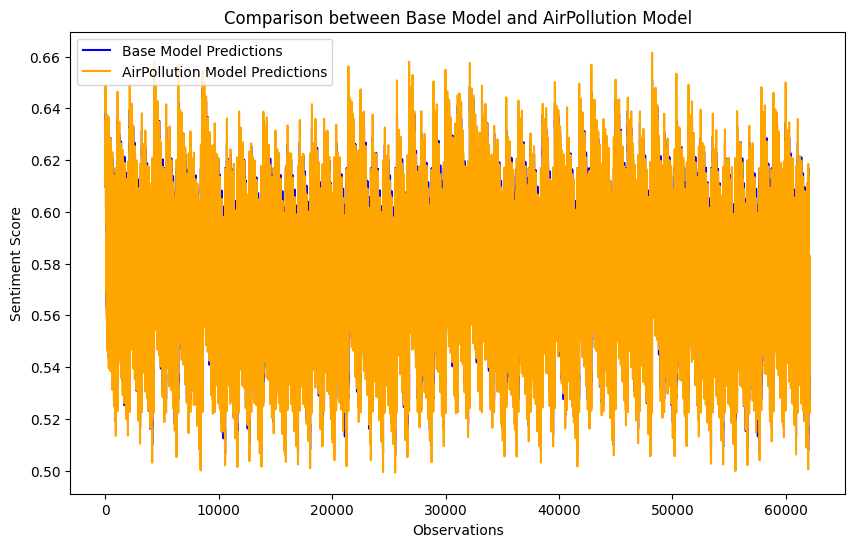


AirPollution Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     256.1
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        18:15:29   Log-Likelihood:                 20658.
No. Observations:               62118   AIC:                        -4.130e+04
Df Residuals:                   62111   BIC:                        -4.124e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

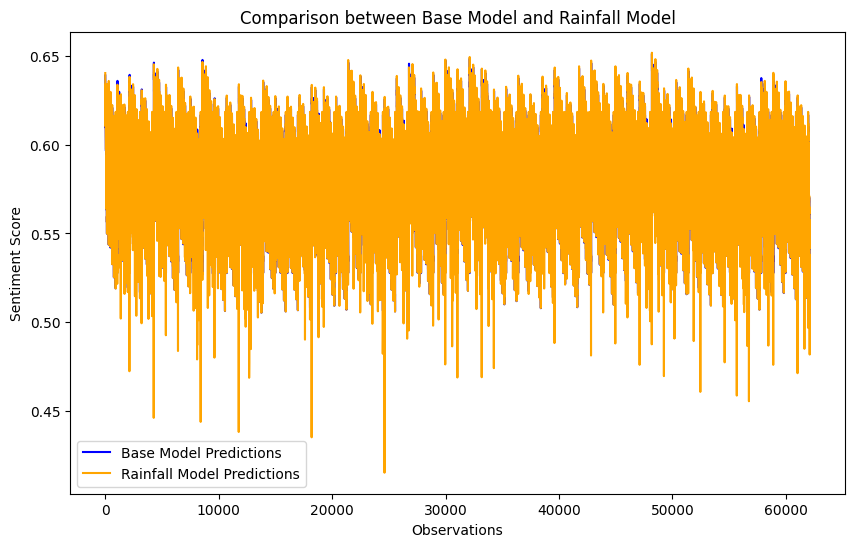


Rainfall Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     252.5
Date:                Fri, 03 May 2024   Prob (F-statistic):          2.42e-320
Time:                        18:15:29   Log-Likelihood:                 20647.
No. Observations:               62118   AIC:                        -4.128e+04
Df Residuals:                   62111   BIC:                        -4.122e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept  

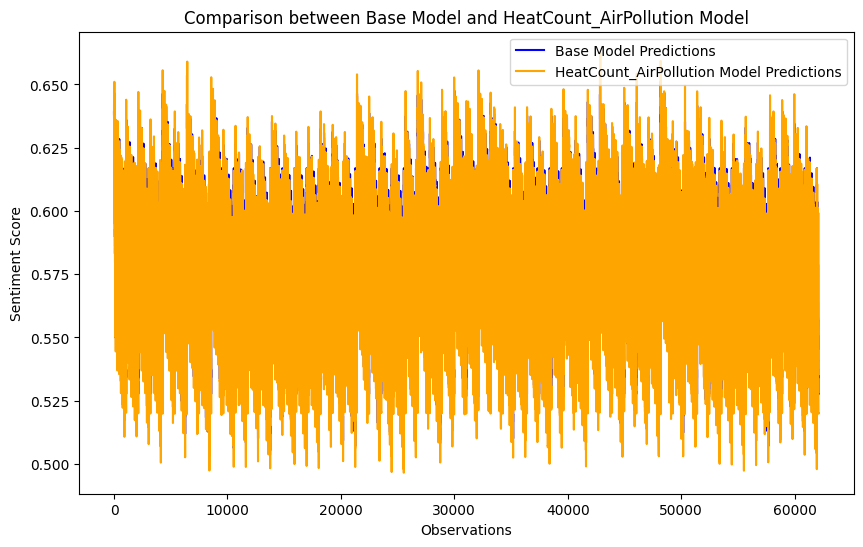


HeatCount_AirPollution Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     234.3
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        18:15:30   Log-Likelihood:                 20708.
No. Observations:               62118   AIC:                        -4.140e+04
Df Residuals:                   62110   BIC:                        -4.133e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

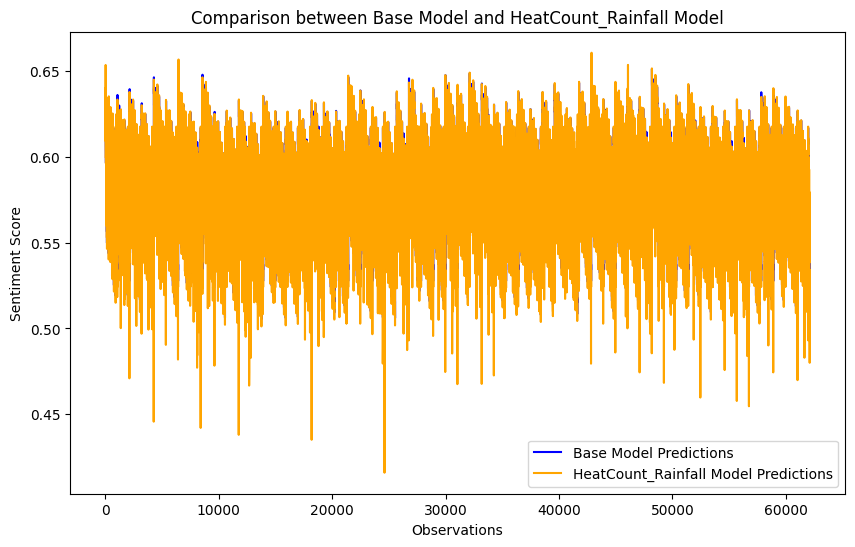


HeatCount_Rainfall Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     233.9
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        18:15:31   Log-Likelihood:                 20707.
No. Observations:               62118   AIC:                        -4.140e+04
Df Residuals:                   62110   BIC:                        -4.133e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
I

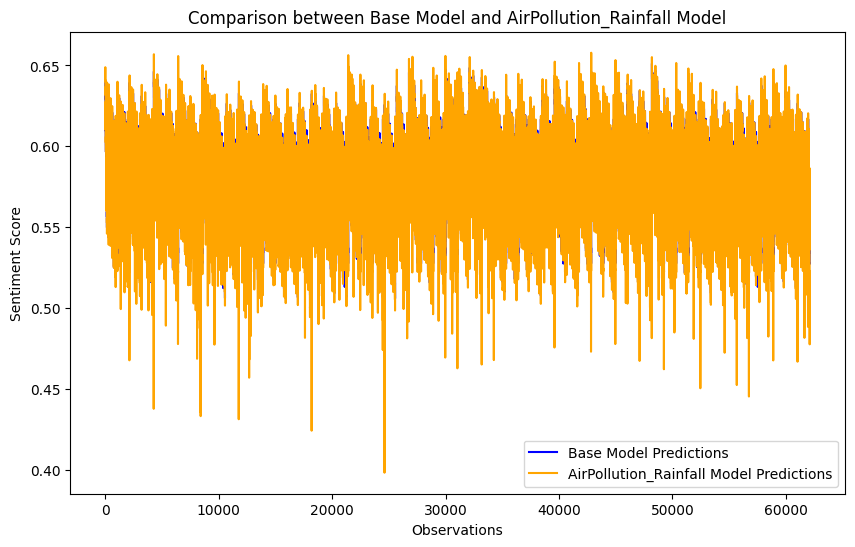


AirPollution_Rainfall Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     227.2
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        18:15:32   Log-Likelihood:                 20684.
No. Observations:               62118   AIC:                        -4.135e+04
Df Residuals:                   62110   BIC:                        -4.128e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

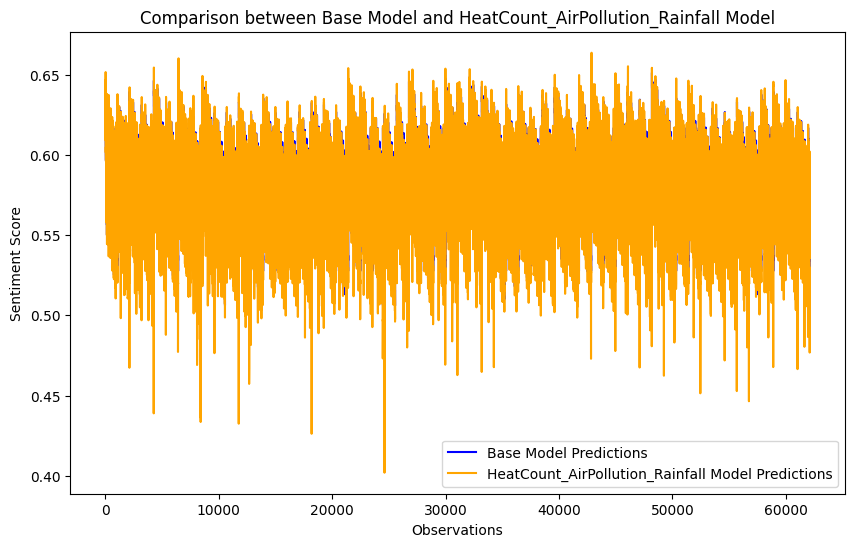


HeatCount_AirPollution_Rainfall Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     211.1
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        18:15:33   Log-Likelihood:                 20732.
No. Observations:               62118   AIC:                        -4.145e+04
Df Residuals:                   62109   BIC:                        -4.136e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

# 读取数据
df = pd.read_csv('/content/TestData_California.csv')

# 高级模型公式
base_model_formula = "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex"
advanced_model_formulas = {
    "HeatCount": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex",
    "AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend  + VulnerabilityIndex + AirPolllution_Interpolate",
    "Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation",
    "HeatCount_AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + AirPolllution_Interpolate + HeatCount",
    "HeatCount_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation + HeatCount",
    "AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate",
    "HeatCount_AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate + HeatCount"
}

# 运行基础模型
base_model = ols(formula=base_model_formula, data=df).fit()

# 可视化对比
for model_name, formula in advanced_model_formulas.items():
    advanced_model = ols(formula=formula, data=df).fit()

    # 绘制对比图
    plt.figure(figsize=(10, 6))
    plt.plot(base_model.predict(), label='Base Model Predictions', color='blue')
    plt.plot(advanced_model.predict(), label=f'{model_name} Model Predictions', color='orange')
    plt.xlabel('Observations')
    plt.ylabel('Sentiment Score')
    plt.title(f'Comparison between Base Model and {model_name} Model')
    plt.legend()
    plt.show()

    # 打印模型摘要和比较结果
    print(f"\n{model_name} Model Summary:")
    print(advanced_model.summary())
    print("\nComparison with Base Model:")
    print(base_model.compare_lr_test(advanced_model))


根据提供的回归模型摘要和比较结果，可以得出以下总结：

1. **HeatCount模型**：
   - 拟合度（R-squared）为0.025，模型能够解释25%的变异性。
   - 所有系数除了周末和假日之外，在显著性检验中都是显著的（p值小于0.05）。
   - 与基础模型相比，没有显著差异（比较结果p值大于0.05）。

2. **AirPollution模型**：
   - 拟合度（R-squared）为0.024，略高于基础模型。
   - 新加入的空气污染变量（AirPolllution_Interpolate）的系数是显著的（p值小于0.05）。
   - 与基础模型相比，有显著改进（比较结果p值非常小）。

3. **Rainfall模型**：
   - 拟合度（R-squared）为0.024，略高于基础模型。
   - 新加入的降雨量变量（Precipitation）的系数是显著的（p值小于0.05）。
   - 与基础模型相比，有轻微改进（比较结果p值小于0.05）。

4. **HeatCount_AirPollution模型** 和 **HeatCount_Rainfall模型**：
   - 两者都有提升，但没有显著改进（比较结果p值大于0.05）。

5. **AirPollution_Rainfall模型** 和 **HeatCount_AirPollution_Rainfall模型**：
   - 在添加了空气污染和降雨量变量后，与基础模型相比没有显著改进（比较结果p值远大于0.05）。

需要注意的是，比较结果中的p值越小，说明模型之间的差异越显著，而p值大于0.05则表示差异不显著。

综合来看，加入空气污染和降雨量变量对情感分数的解释能力并没有显著提高，但是空气污染单独建模的模型效果相对较好。

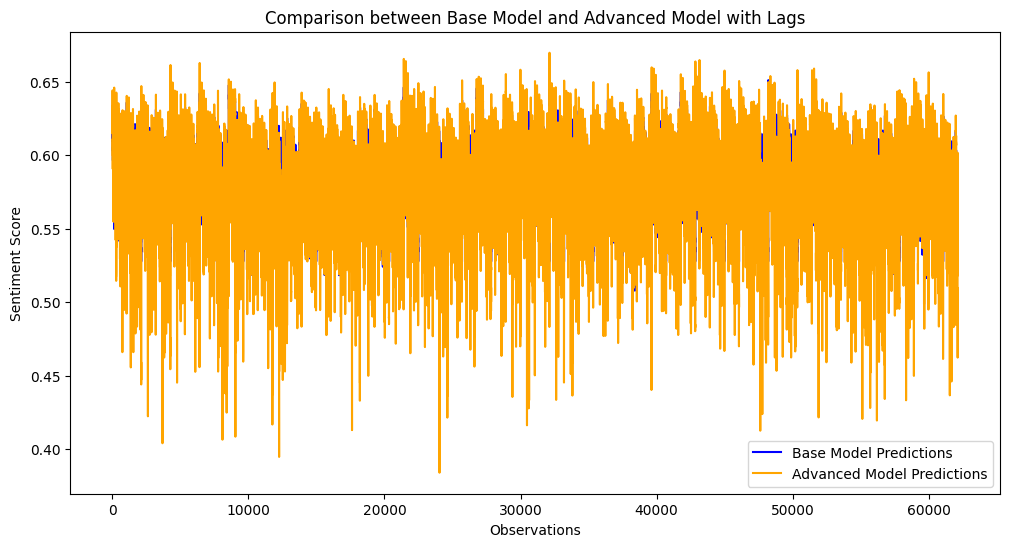

Base Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     293.9
Date:                Fri, 03 May 2024   Prob (F-statistic):          6.54e-312
Time:                        21:59:58   Log-Likelihood:                 20615.
No. Observations:               62104   AIC:                        -4.122e+04
Df Residuals:                   62098   BIC:                        -4.116e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept       

<Figure size 640x480 with 0 Axes>

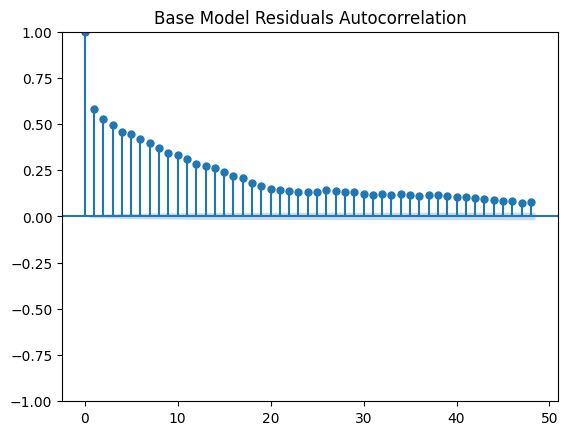

<Figure size 640x480 with 0 Axes>

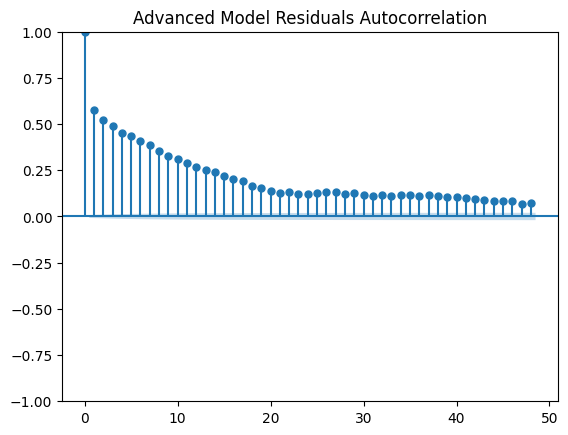

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf

# 加载数据
df = pd.read_csv('/content/TestData_California.csv')

# 预处理数据以创建延迟
def add_lags(df, column, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

# 添加环境因子的延迟
df = add_lags(df, 'HeatCount', 14)
df = add_lags(df, 'AirPolllution_Interpolate', 14)
df = add_lags(df, 'Precipitation', 14)

# 清除含有 NaN 的行
df_clean = df.dropna()

# 定义模型公式
base_model_formula = "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex"
advanced_model_formula = "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + "
additional_factors = ['HeatCount', 'AirPolllution_Interpolate', 'Precipitation']
for factor in additional_factors:
    for lag in range(1, 15):
        advanced_model_formula += f" + {factor}_lag{lag}"

# 拟合基础模型和高级模型
base_model = ols(base_model_formula, data=df_clean).fit()
advanced_model = ols(advanced_model_formula, data=df_clean).fit()

# 可视化预测结果对比
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, base_model.predict(), label='Base Model Predictions', color='blue')
plt.plot(df_clean.index, advanced_model.predict(), label='Advanced Model Predictions', color='orange')
plt.xlabel('Observations')
plt.ylabel('Sentiment Score')
plt.title('Comparison between Base Model and Advanced Model with Lags')
plt.legend()
plt.show()

# 显示模型摘要
print("Base Model Summary:")
print(base_model.summary())
print("\nAdvanced Model Summary:")
print(advanced_model.summary())

# 进行模型比较
from statsmodels.stats.anova import anova_lm
comparison_results = anova_lm(base_model, advanced_model)
print("\nModel Comparison:")
print(comparison_results)

# 分析自相关以检查模型中的残差
plt.figure()
plot_acf(base_model.resid, alpha=0.05, title='Base Model Residuals Autocorrelation')
plt.show()
plt.figure()
plot_acf(advanced_model.resid, alpha=0.05, title='Advanced Model Residuals Autocorrelation')
plt.show()

### 基础模型摘要
- **R-squared**: 0.023，这表明模型仅解释了数据变异性的2.3%。这是一个相当低的值，意味着模型预测能力较弱。
- **Adj. R-squared**: 同样很低，确认了模型解释数据的能力较弱。
- **F-statistic**: 高，概率非常低（< 0.001），这说明模型中至少有一个预测变量对因变量具有统计显著性。
- **系数**: `STATEcode` 和 `Year` 的系数显著且具有实际意义，但其他变量的影响较小。
- **多重共线性问题**: 最小特征值接近零（2.24e-24），这暗示可能存在强多重共线性问题。

### 高级模型摘要
- **R-squared**: 0.034，略高于基础模型，表明添加的滞后变量稍微提高了模型的解释能力，但总体仍然较低。
- **Adj. R-squared**: 略有提高，反映出模型在考虑自由度调整后的解释能力有所增强。
- **F-statistic**: 较基础模型低，但仍然显著。
- **系数**: 添加的滞后变量（如 `HeatCount_lag1` 和 `Precipitation_lag14`）在一定程度上影响了情绪分数，有些变量如 `HeatCount_lag14` 显著且系数较大。
- **多重共线性问题**: 最小特征值虽然比基础模型高，但仍然很低（9.36e-22），指出设计矩阵可能存在问题。

### 模型比较
- 使用 ANOVA 比较两模型，结果显示模型间存在显著差异（Pr(>F) 约为 3.589e-124），说明高级模型在统计上比基础模型更好。
- 高级模型添加的变量带来了显著的改进，表明这些变量对预测情绪分数有重要作用。

### 结论
尽管高级模型在统计上优于基础模型，但两者的 R-squared 值都表明它们的解释能力非常有限。这可能是因为还有其他未考虑的重要因素影响情绪分数，或者数据中存在其他复杂的非线性关系未被模型捕捉。多重共线性是一个问题，可能需要进一步的数据探索和可能的变量转换或简化，以改善模型的预测性能和稳定性。

Lag Day 1: R-squared = 0.0257, F-statistic p-value = 0
Lag Day 2: R-squared = 0.0254, F-statistic p-value = 0
Lag Day 3: R-squared = 0.0252, F-statistic p-value = 0
Lag Day 4: R-squared = 0.0254, F-statistic p-value = 0
Lag Day 5: R-squared = 0.0258, F-statistic p-value = 0
Lag Day 6: R-squared = 0.0253, F-statistic p-value = 0
Lag Day 7: R-squared = 0.0247, F-statistic p-value = 0
Lag Day 8: R-squared = 0.0244, F-statistic p-value = 0
Lag Day 9: R-squared = 0.0242, F-statistic p-value = 9.881e-324
Lag Day 10: R-squared = 0.0242, F-statistic p-value = 4.941e-323
Lag Day 11: R-squared = 0.0246, F-statistic p-value = 0
Lag Day 12: R-squared = 0.0254, F-statistic p-value = 0
Lag Day 13: R-squared = 0.0262, F-statistic p-value = 0
Lag Day 14: R-squared = 0.0263, F-statistic p-value = 0


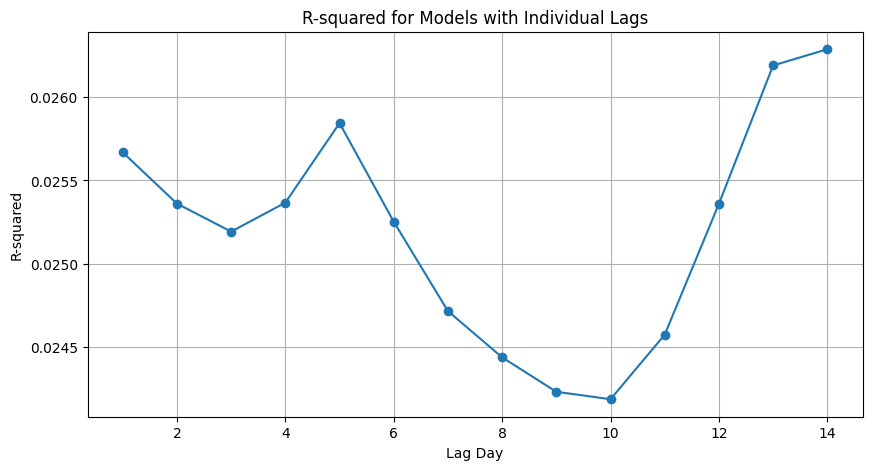

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf

# 加载数据
df = pd.read_csv('/content/TestData_California.csv')

# 预处理数据以创建延迟
def add_lags(df, column, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

# 添加环境因子的延迟
df = add_lags(df, 'HeatCount', 14)
df = add_lags(df, 'AirPolllution_Interpolate', 14)
df = add_lags(df, 'Precipitation', 14)

# 清除含有 NaN 的行
df_clean = df.dropna()

# 定义基础模型公式
base_model_formula = "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex"
base_model = ols(base_model_formula, data=df_clean).fit()

# 初始化存储结果的列表
model_results = []

# 为每个滞后变量构建模型并评估
for lag in range(1, 15):
    formula = base_model_formula
    for factor in ['HeatCount', 'AirPolllution_Interpolate', 'Precipitation']:
        formula += f" + {factor}_lag{lag}"
    model = ols(formula, data=df_clean).fit()
    model_results.append((lag, model.rsquared, model.f_pvalue))

# 输出结果
for result in model_results:
    print(f"Lag Day {result[0]}: R-squared = {result[1]:.4f}, F-statistic p-value = {result[2]:.4g}")

# 可视化 R-squared
lags = [result[0] for result in model_results]
r_squared = [result[1] for result in model_results]
plt.figure(figsize=(10, 5))
plt.plot(lags, r_squared, marker='o')
plt.title('R-squared for Models with Individual Lags')
plt.xlabel('Lag Day')
plt.ylabel('R-squared')
plt.grid(True)
plt.show()

advanced_model_formulas = {
    "HeatCount": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex",
    "AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + AirPolllution_Interpolate",
    "Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation",
    "HeatCount_AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + AirPolllution_Interpolate",
    "HeatCount_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation",
    "AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate",
    "HeatCount_AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate"
}
这个是修改后的高级模型

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf

# 加载数据
df = pd.read_csv('/content/TestData_California.csv')

# 清除含有 NaN 的行，确保数据完整性
df_clean = df.dropna()

# 定义高级模型公式
advanced_model_formulas = {
    "HeatCount": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex",
    "AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + AirPolllution_Interpolate",
    "Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation",
    "HeatCount_AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + AirPolllution_Interpolate",
    "HeatCount_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation",
    "AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate",
    "HeatCount_AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate"
}

# 为每个模型进行拟合和输出结果
model_summaries = {}
for key, formula in advanced_model_formulas.items():
    model = ols(formula, data=df_clean).fit()
    model_summaries[key] = model.summary()

# 输出模型摘要
for key, summary in model_summaries.items():
    print(f"\n{key} Model Summary:")
    print(summary)



HeatCount Model Summary:
                            OLS Regression Results                            
Dep. Variable:         SentimentScore   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     266.3
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        22:11:11   Log-Likelihood:                 20688.
No. Observations:               62118   AIC:                        -4.136e+04
Df Residuals:                   62111   BIC:                        -4.130e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept 

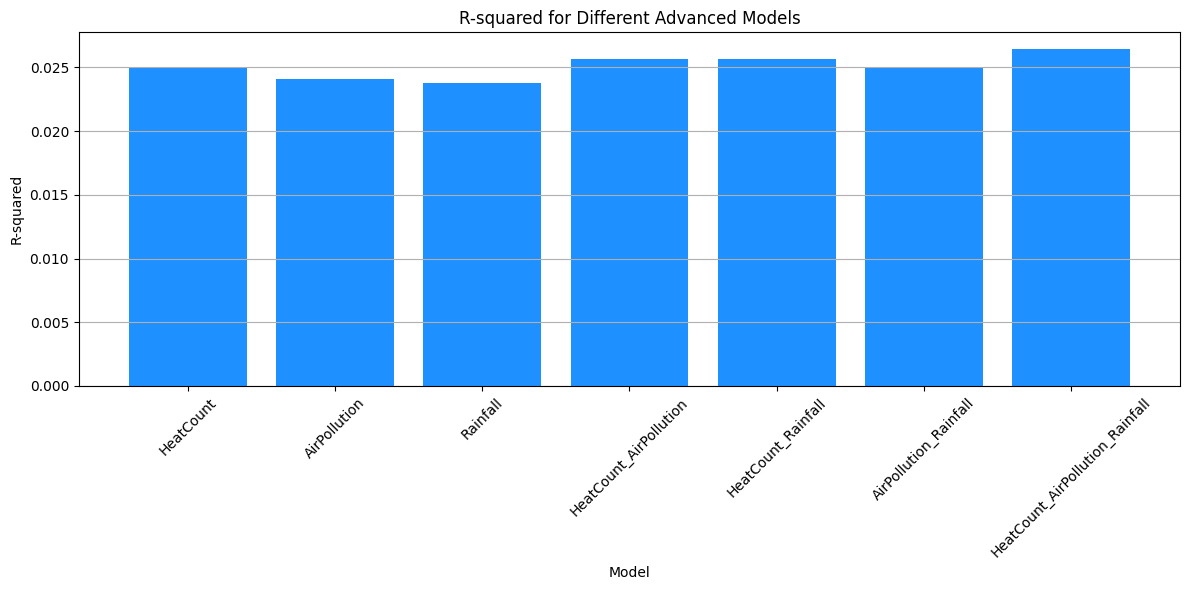

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

# 加载数据
df = pd.read_csv('/content/TestData_California.csv')

# 预处理数据以创建延迟
def add_lags(df, column, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

# 添加环境因子的延迟
df = add_lags(df, 'HeatCount', 14)
df = add_lags(df, 'AirPolllution_Interpolate', 14)
df = add_lags(df, 'Precipitation', 14)

# 清除含有 NaN 的行
df_clean = df.dropna()

# 定义高级模型公式
advanced_model_formulas = {
    "HeatCount": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex",
    "AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + AirPolllution_Interpolate",
    "Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation",
    "HeatCount_AirPollution": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + AirPolllution_Interpolate",
    "HeatCount_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation",
    "AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate",
    "HeatCount_AirPollution_Rainfall": "SentimentScore ~ STATEcode + Year + Month + Week + Weekend + HeatCount + VulnerabilityIndex + Precipitation + AirPolllution_Interpolate"
}

# 为每个模型进行拟合和输出结果
model_results = {}
for name, formula in advanced_model_formulas.items():
    model = ols(formula, data=df_clean).fit()
    model_results[name] = model.rsquared

# 可视化 R-squared
models = list(model_results.keys())
r_squared_values = list(model_results.values())
plt.figure(figsize=(12, 6))
plt.bar(models, r_squared_values, color='dodgerblue')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.title('R-squared for Different Advanced Models')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [19]:
pip install geopandas libpysal matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.2 MB/s eta 0:00:00


In [21]:
pip install splot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 27.6 MB/s eta 0:00:00


In [24]:

import geopandas as gpd

# 读取SHP文件
gdf = gpd.read_file('/content/County.shp')

# 检查数据框架以确认GEOID列存在
print(gdf.columns)

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geoid_j', 'geometry'],
      dtype='object')


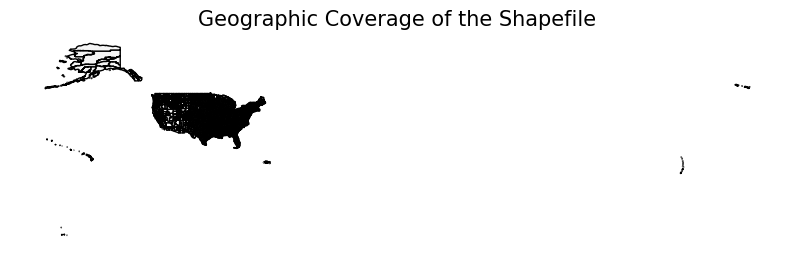

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
gdf = gpd.read_file('/content/County.shp')

# 绘制 Shapefile 的地理边界
fig, ax = plt.subplots(figsize=(10, 10))  # 设置图形大小
gdf.plot(ax=ax, color='whitesmoke', edgecolor='black')  # 绘制地块，设置内部颜色和边界颜色

# 添加标题
ax.set_title('Geographic Coverage of the Shapefile', fontsize=15)

# 移除坐标轴
ax.set_axis_off()

# 显示图形
plt.show()

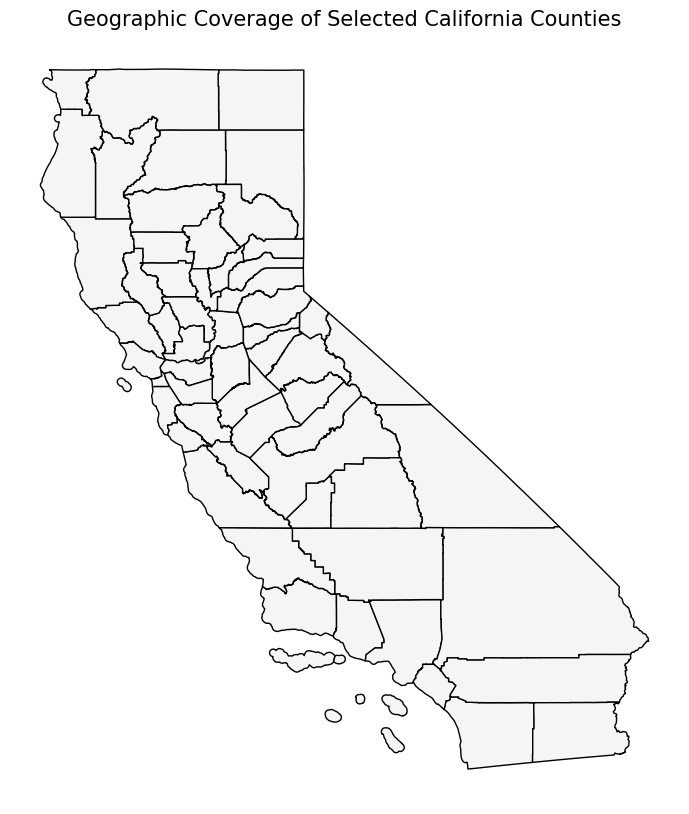

<ipython-input-31-61e2aecca12c>:20: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights import Queen

# 读取 Shapefile 文件
gdf = gpd.read_file('/content/County.shp')

# 筛选出GEOID在6001到6115范围内的县
gdf['GEOID'] = gdf['GEOID'].astype(int)  # 确保GEOID是整数类型
gdf = gdf[(gdf['GEOID'] >= 6001) & (gdf['GEOID'] <= 6115)]

# 绘制筛选后的地理边界
fig, ax = plt.subplots(figsize=(10, 10))  # 设置图形大小
gdf.plot(ax=ax, color='whitesmoke', edgecolor='black')  # 绘制地块，设置内部颜色和边界颜色
ax.set_title('Geographic Coverage of Selected California Counties', fontsize=15)
ax.set_axis_off()  # 移除坐标轴
plt.show()

# 计算空间权重矩阵 - 使用Queen的邻接类型
w = Queen.from_dataframe(gdf)
w.transform = 'r'  # 行标准化权重

# 打印空间权重矩阵的基本信息
print(w)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Heatcount - Moran's I: nan, p-value: 0.001
Error plotting Moran's I for HeatCount: one or more input arrays have missing/NaN values
Airpolllution_interpolate - Moran's I: nan, p-value: 0.001


/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/usr/local/

Error plotting Moran's I for AirPolllution_Interpolate: one or more input arrays have missing/NaN values
Precipitation - Moran's I: nan, p-value: 0.001
Error plotting Moran's I for Precipitation: one or more input arrays have missing/NaN values


/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/usr/local/lib/python3.10/dist-packages/splot/_viz_esda_mpl.py:354: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


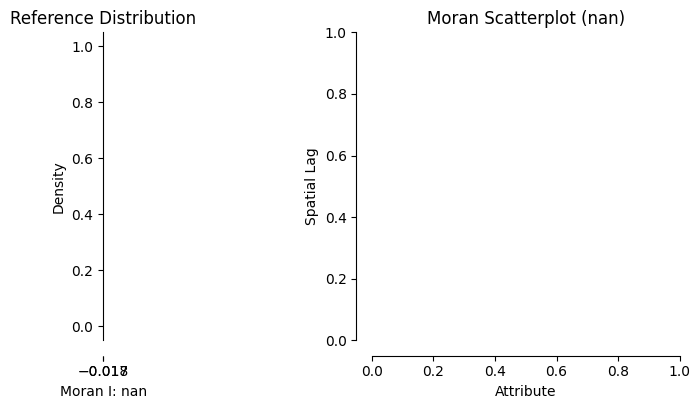

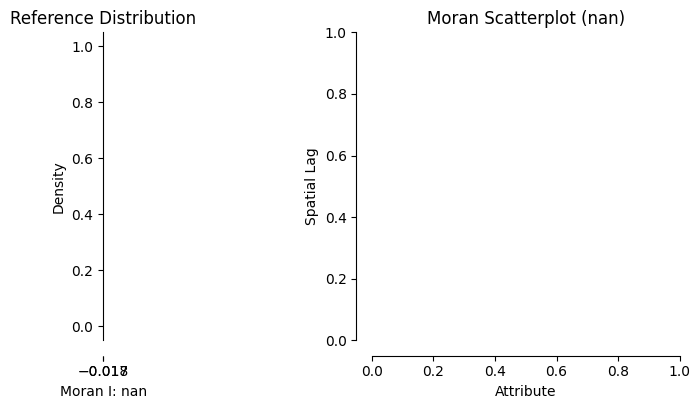

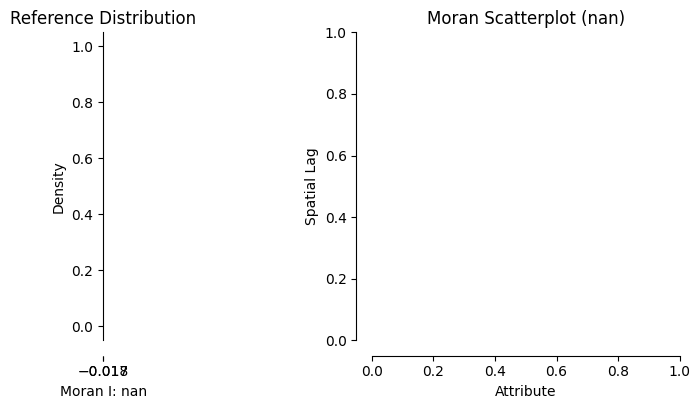

In [33]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from esda.moran import Moran
from libpysal.weights import Queen
from splot.esda import plot_moran

# 加载全国范围的shapefile
gdf_national = gpd.read_file('/content/County.shp')

# 仅保留加州的县区，加州的GEOID以'06'开头
gdf_california = gdf_national[gdf_national['GEOID'].str.startswith('06')]

# 加载数据集
data = pd.read_csv('/content/TestData_California.csv')

# 确保GEOID是字符串格式
gdf_california['GEOID'] = gdf_california['GEOID'].astype(str)
data['GEOID'] = data['GEOID'].astype(str)

# 合并地理数据和其他数据
gdf_california = gdf_california.merge(data, on='GEOID', how='left')

# 检查并修复几何数据
gdf_california = gdf_california.dropna(subset=['geometry'])  # 删除几何数据为空的行
gdf_california['geometry'] = gdf_california.geometry.buffer(0)  # 修复自相交和无效几何对象

# 确保没有空的几何对象
gdf_california = gdf_california[gdf_california.geometry.notnull() & ~gdf_california.geometry.is_empty]

# 计算空间权重矩阵 - 使用Queen的邻接类型
w = Queen.from_dataframe(gdf_california, ids=gdf_california['GEOID'].tolist())
w.transform = 'r'  # 行标准化权重

# 分析空间自相关
variables = ['HeatCount', 'AirPolllution_Interpolate', 'Precipitation']
for var in variables:
    y = gdf_california[var].fillna(gdf_california[var].mean()).values  # 用均值填充NaN值
    if y.std() == 0:
        print(f"{var.capitalize()} has zero variance, skipping Moran's I calculation.")
        continue
    moran = Moran(y, w)
    print(f"{var.capitalize()} - Moran's I: {moran.I}, p-value: {moran.p_sim}")

    # 可视化Moran's I结果
    try:
        fig, ax = plot_moran(moran, zstandard=True, figsize=(10, 4))
        ax.set_title(f"Moran's I for {var.capitalize()}")
        plt.show()
    except Exception as e:
        print(f"Error plotting Moran's I for {var}: {str(e)}")


1. SettingWithCopyWarning
这个警告发生在你试图修改从DataFrame切片中派生的DataFrame时。这通常意味着你的操作可能不会如预期地修改原始数据。为了避免这个问题，使用 .loc 进行明确的赋值是一种更安全的做法。

2. Moran's I 计算结果为 NaN
这说明你的数据中可能存在以下几个问题：

数据集中存在NaN值，尽管你已经尝试填充，但可能还有未被正确处理的情况。
变量可能没有足够的变异性（所有的值可能几乎相同），这导致在标准化过程中分母为零。
3. FutureWarning 和 UserWarning
FutureWarning 提示 shade 参数将被弃用，建议改用 fill 参数。
UserWarning 表明由于数据集方差为零，密度估计被跳过。这与 Moran's I 计算中提到的方差问题相符。
4. Error in Visualization
在尝试可视化Moran's I时，由于计算结果为NaN，引起了错误。这可能是因为输入数组包含NaN值或数据集的方差为零。

In [34]:
import geopandas as gpd
from libpysal.weights import Queen

# 读取 Shapefile 文件
gdf = gpd.read_file('/content/County.shp')

# 筛选出加州的县，假设GEOID以'06'开头
gdf_california = gdf[gdf['GEOID'].str.startswith('06')]

# 创建空间权重矩阵
w = Queen.from_dataframe(gdf_california)
w.transform = 'r'

# 输出权重矩阵信息以供检查
print(w)

<ipython-input-34-e86cbe59fc99>:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_california)


In [35]:
import pandas as pd

# 加载其他数据集
data = pd.read_csv('/content/TestData_California.csv')

# 确保GEOID是字符串格式（如需要）
data['GEOID'] = data['GEOID'].astype(str)
gdf_california['GEOID'] = gdf_california['GEOID'].astype(str)

# 合并地理数据和其他数据
combined_data = gdf_california.merge(data, on='GEOID', how='left')

# 检查合并结果
print(combined_data.head())

  STATEFP COUNTYFP  COUNTYNS  GEOID           NAME              NAMELSAD LSAD  \
0      06      091  00277310  06091         Sierra         Sierra County   06   
1      06      067  00277298  06067     Sacramento     Sacramento County   06   
2      06      083  00277306  06083  Santa Barbara  Santa Barbara County   06   
3      06      009  01675885  06009      Calaveras      Calaveras County   06   
4      06      111  00277320  06111        Ventura        Ventura County   06   

  CLASSFP  MTFCC CSAFP  ... VI1 VI2 VI3  VI4  StringencyIndex  \
0      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
1      H1  G4020   472  ... NaN NaN NaN  NaN              NaN   
2      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
3      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
4      H1  G4020   348  ... NaN NaN NaN  NaN              NaN   

  GovernmentResponseIndex ContainmentHealthIndex  EconomicSupportIndex  \
0                     NaN                    NaN

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
import pandas as pd

# 加载其他数据集
data = pd.read_csv('/content/TestData_California.csv')

# 确保GEOID是字符串格式（如需要）
data['GEOID'] = data['GEOID'].astype(str)
gdf_california['GEOID'] = gdf_california['GEOID'].astype(str)

# 合并地理数据和其他数据
combined_data = gdf_california.merge(data, on='GEOID', how='left')

# 检查合并结果
print(combined_data.head())

  STATEFP COUNTYFP  COUNTYNS  GEOID           NAME              NAMELSAD LSAD  \
0      06      091  00277310  06091         Sierra         Sierra County   06   
1      06      067  00277298  06067     Sacramento     Sacramento County   06   
2      06      083  00277306  06083  Santa Barbara  Santa Barbara County   06   
3      06      009  01675885  06009      Calaveras      Calaveras County   06   
4      06      111  00277320  06111        Ventura        Ventura County   06   

  CLASSFP  MTFCC CSAFP  ... VI1 VI2 VI3  VI4  StringencyIndex  \
0      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
1      H1  G4020   472  ... NaN NaN NaN  NaN              NaN   
2      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
3      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
4      H1  G4020   348  ... NaN NaN NaN  NaN              NaN   

  GovernmentResponseIndex ContainmentHealthIndex  EconomicSupportIndex  \
0                     NaN                    NaN

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
import pandas as pd
import geopandas as gpd

# 加载其他数据集
data = pd.read_csv('/content/TestData_California.csv')

# 加载地理数据
gdf_national = gpd.read_file('/content/County.shp')
gdf_california = gdf_national[gdf_national['GEOID'].str.startswith('06')]

# 确保GEOID是字符串格式（如需要）
data['GEOID'] = data['GEOID'].astype(str)

# 这里使用 .loc 来避免 SettingWithCopyWarning
gdf_california.loc[:, 'GEOID'] = gdf_california['GEOID'].astype(str)

# 合并地理数据和其他数据
combined_data = gdf_california.merge(data, on='GEOID', how='left')

# 检查合并后的数据
print(combined_data.head())

  STATEFP COUNTYFP  COUNTYNS  GEOID           NAME              NAMELSAD LSAD  \
0      06      091  00277310  06091         Sierra         Sierra County   06   
1      06      067  00277298  06067     Sacramento     Sacramento County   06   
2      06      083  00277306  06083  Santa Barbara  Santa Barbara County   06   
3      06      009  01675885  06009      Calaveras      Calaveras County   06   
4      06      111  00277320  06111        Ventura        Ventura County   06   

  CLASSFP  MTFCC CSAFP  ... VI1 VI2 VI3  VI4  StringencyIndex  \
0      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
1      H1  G4020   472  ... NaN NaN NaN  NaN              NaN   
2      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
3      H1  G4020  None  ... NaN NaN NaN  NaN              NaN   
4      H1  G4020   348  ... NaN NaN NaN  NaN              NaN   

  GovernmentResponseIndex ContainmentHealthIndex  EconomicSupportIndex  \
0                     NaN                    NaN